In [1]:
import pickle as pkl

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Conv1D, Flatten, MaxPooling1D, AveragePooling1D, Concatenate, LeakyReLU
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

### Get postive samples

In [36]:
drugbank = pkl.load(open('data/drugbank_embds.pkl', 'rb'))

In [3]:
drugbank['target_gene_code'] = drugbank['target_gene'].apply(lambda x: ''.join(list(x.split('\n')[1:])))
drugbank['target_amino_code'] = drugbank['target_amino'].apply(lambda x: ''.join(list(x.split('\n')[1:])))

In [4]:
with open ('data/chem_cid_SMILE_fngr_vector_fngr.pickle', 'rb') as f:
    smiles_df = pkl.load(f)
    
smiles_df['cid'] = smiles_df['cid'].astype(int)
drugbank = pd.merge(smiles_df, drugbank, right_on = 'pubchem_id', left_on = 'cid', how = 'right')

In [5]:
drugbank = drugbank[['drug_id', 'target_id', 'fingerprint', 'target_gene_code']]
drugbank = drugbank[~ drugbank['fingerprint'].isna()]
drugbank = drugbank.rename(columns = {'fingerprint': 'drug_fingerprint_code', 'target_id': 'gene_id'})

In [6]:
drugbank

,drug_id,gene_id,drug_fingerprint_code,target_gene_code
0,DB03313,BE0001349,2246728737 3545365497 2246699815 2664995851 86...,ATGGTCTCAGGAACGGTGGGCAGAGGTACGGCGCTGGGCGCGGTGC...
1,DB03313,BE0004335,2246728737 3545365497 2246699815 2664995851 86...,ATGCAAAATCAATTAAATGAATTAAAACGAAAAATGCTGGAATTTT...
2,DB03313,BE0004290,2246728737 3545365497 2246699815 2664995851 86...,ATGAACAAACCAACGATTCTGCGCCTAATCAAGTATCTGAGCATTA...
3,DB03313,BE0003624,2246728737 3545365497 2246699815 2664995851 86...,ATGAGACTGATTTGTATGAGAAAATTTAACAGCCATTCGATTCCGA...
4,DB03313,BE0004644,2246728737 3545365497 2246699815 2664995851 86...,ATGAAATTAGATAAATTATTTGAGAAATTTCTTTCTCTTTTTAAAA...
...,...,...,...,...
14071,DB02843,BE0001369,2245384272 3153477100 2976033787 1916236386 29...,ATGAGCACTGTAAAAGCACCGACGCTGCCCGCCAGCATCTTCCGCG...
14072,DB02843,BE0000916,2245384272 3153477100 2976033787 1916236386 29...,ATGTCCCGGCCCCTGTCAGACCAAGAGAAAAGAAAGCAAATCAGTG...
14073,DB02843,BE0002493,2245384272 3153477100 2976033787 1916236386 29...,ATGAAACGCAAGGGCATCATCCTCGCCGGAGGCTCGGGCACCCGCC...
14074,DB02843,BE0001698,2245384272 3153477100 2976033787 1916236386 29...,ATGTCACAACCTATTTTTAACGATAAGCAATTTCAGGAAGCGCTTT...


### Get DrugID -> Finderprint mapping from positive samples

In [7]:
drug_map = drugbank[['drug_id', 'drug_fingerprint_code']].drop_duplicates('drug_id').set_index('drug_id')
target_map = drugbank[['gene_id', 'target_gene_code']].drop_duplicates('gene_id').set_index('gene_id')

In [8]:
negative_df = pd.read_csv('negative_samples/negative_samples_thrsh:12')[['node_0','node_1','shortest_path']] 
negative_df = negative_df.rename(columns = {'node_0': 'drug_id', 'node_1': 'gene_id'})
negative_df = negative_df[negative_df['drug_id'].str.contains('DB') & negative_df['gene_id'].str.contains('BE')]

In [9]:
negative_df = pd.merge(negative_df, drug_map, left_on = 'drug_id', right_index = True, how = 'left')
negative_df = pd.merge(negative_df, target_map, left_on = 'gene_id', right_index = True, how = 'left')

In [10]:
negative_df.head()

,drug_id,gene_id,shortest_path,drug_fingerprint_code,target_gene_code
1,DB04481,BE0002266,12.0,2245384272 4022716898 2245273601 1735424888 22...,ATGGCGACCTCCACGGGTCGCTGGCTTCTCCTCCGGCTTGCACTAT...
3,DB04481,BE0000206,13.0,2245384272 4022716898 2245273601 1735424888 22...,ATGTTTGACTGTATGGATGTTCTGTCAGTGAGTCCTGGGCAAATCC...
4,DB04481,BE0002401,13.0,2245384272 4022716898 2245273601 1735424888 22...,ATGGCAGCAGACCTGGGCCCCTGGAATGACACCATCAATGGCACCT...
6,DB04481,BE0004180,13.0,2245384272 4022716898 2245273601 1735424888 22...,ATGACGGAAAACAAAGGATCTTCTCAGCCTAAGAAAAACGGTAATA...
10,DB04481,BE0002840,12.0,2245384272 4022716898 2245273601 1735424888 22...,ATGAAATTTCTTCTGGACATCCTCCTGCTTCTCCCGTTACTGATCG...


#### Note: Around 13% of negative samples don't match a drug id. Since the number is small, we ignore it for now

In [11]:
len(negative_df[(negative_df['target_gene_code'].isna()) |
                (negative_df['drug_fingerprint_code'].isna())])/len(negative_df)

negative_df = negative_df[(~ negative_df['target_gene_code'].isna()) &
                (~ negative_df['drug_fingerprint_code'].isna())]

In [12]:
negative_df['Y'] = 0
drugbank['Y'] = 1
drugbank = drugbank.append(negative_df.sample(len(drugbank)))
drugbank = drugbank.drop('shortest_path', axis = 1)

/home/omai.r/.local/lib/python3.5/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [13]:
drugbank[drugbank['target_gene_code'].str.contains('S').isna()]

,Y,drug_fingerprint_code,drug_id,gene_id,target_gene_code


In [14]:
drugbank = drugbank[~ drugbank['drug_fingerprint_code'].str.contains('n')]

#### The dataset is clean and balanced

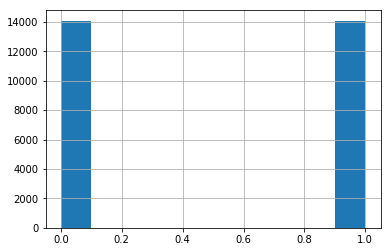

In [15]:
drugbank['Y'].hist()

#### Preprocessing fingerprints to feed to CNN

In [16]:
label_encoder = LabelEncoder()
label_encoder.fit(list(drugbank['target_gene_code'].iloc[0]))

LabelEncoder()

In [17]:
gene_chars = set(list(drugbank['target_gene_code'].iloc[0]))

In [18]:
drugbank['target_gene_encoded'] = drugbank['target_gene_code'].apply(\
                                   lambda x: label_encoder.transform([i for i in list(x) if i in gene_chars]))

In [19]:
drugbank['drug_fingerprint_encoded'] = drugbank['drug_fingerprint_code'].apply(lambda x: [int(i) for i in x.replace(' ', '')])

In [20]:
drugbank.head()

,Y,drug_fingerprint_code,drug_id,gene_id,target_gene_code,target_gene_encoded,drug_fingerprint_encoded
0,1,2246728737 3545365497 2246699815 2664995851 86...,DB03313,BE0001349,ATGGTCTCAGGAACGGTGGGCAGAGGTACGGCGCTGGGCGCGGTGC...,"[0, 3, 2, 2, 3, 1, 3, 1, 0, 2, 2, 0, 0, 1, 2, ...","[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 4, 5, 3, ..."
1,1,2246728737 3545365497 2246699815 2664995851 86...,DB03313,BE0004335,ATGCAAAATCAATTAAATGAATTAAAACGAAAAATGCTGGAATTTT...,"[0, 3, 2, 1, 0, 0, 0, 0, 3, 1, 0, 0, 3, 3, 0, ...","[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 4, 5, 3, ..."
2,1,2246728737 3545365497 2246699815 2664995851 86...,DB03313,BE0004290,ATGAACAAACCAACGATTCTGCGCCTAATCAAGTATCTGAGCATTA...,"[0, 3, 2, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 2, ...","[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 4, 5, 3, ..."
3,1,2246728737 3545365497 2246699815 2664995851 86...,DB03313,BE0003624,ATGAGACTGATTTGTATGAGAAAATTTAACAGCCATTCGATTCCGA...,"[0, 3, 2, 0, 2, 0, 1, 3, 2, 0, 3, 3, 3, 2, 3, ...","[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 4, 5, 3, ..."
4,1,2246728737 3545365497 2246699815 2664995851 86...,DB03313,BE0004644,ATGAAATTAGATAAATTATTTGAGAAATTTCTTTCTCTTTTTAAAA...,"[0, 3, 2, 0, 0, 0, 3, 3, 0, 2, 0, 3, 0, 0, 0, ...","[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 4, 5, 3, ..."


#### Calculate length mismatches and pad

In [21]:
drugbank['target_gene_encoded_len'] = drugbank['target_gene_encoded']\
                                    .apply(lambda x: len(x))
drugbank['drug_fingerprint_encoded_len'] = drugbank['drug_fingerprint_encoded']\
                                    .apply(lambda x: len(x))

In [22]:
drugbank['mismatch'] = drugbank[['target_gene_encoded', 'drug_fingerprint_encoded']]\
                        .apply(lambda x: len(x['target_gene_encoded']) - len(x['drug_fingerprint_encoded']), axis = 1)

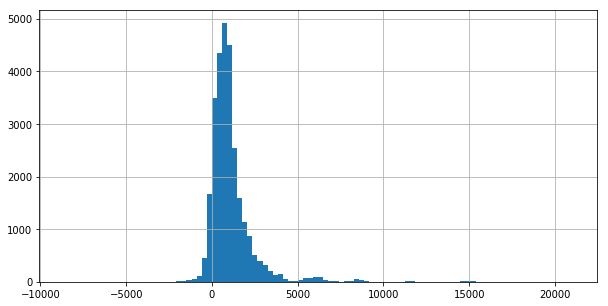

In [23]:
drugbank['mismatch'].hist(bins = 100, figsize = (10, 5))

In [24]:
print('95 percent of the mismatches are of the range %f to %f' % (max(drugbank['mismatch'].value_counts()) - np.std(drugbank['mismatch'].value_counts()),
                                                           max(drugbank['mismatch'].value_counts()) + np.std(drugbank['mismatch'].value_counts())))

95 percent of the mismatches are of the range 22.982630 to 35.017370


In [25]:
max_target_gene_encoded_len = max(drugbank['target_gene_encoded_len'])
max_drug_fingerprint_encoded_len = max(drugbank['drug_fingerprint_encoded_len'])

In [31]:
drugbank['target_gene_encoded_mismatch'] = max_target_gene_encoded_len - drugbank['target_gene_encoded_len']

In [27]:
drugbank['drug_fingerprint_encoded_mismatch'] = max_drug_fingerprint_encoded_len - drugbank['drug_fingerprint_encoded_len'] 

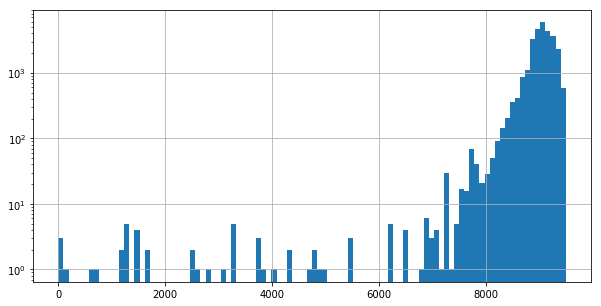

In [35]:
drugbank['drug_fingerprint_encoded_mismatch'].hist(bins = 100, figsize = (10, 5), log = True)

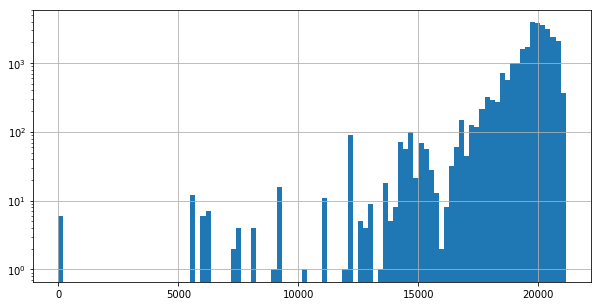

In [34]:
drugbank['target_gene_encoded_mismatch'].hist(bins = 100, figsize = (10, 5), log = True)

In [ ]:
## 

In [ ]:
model = Sequential()
model.add(Conv1D(filters=30, kernel_size=2, input_shape=input_shape,kernel_initializer= 'uniform')) 
model.add(LeakyReLU(alpha=0.3))
model.add(Conv1D(filters=10, kernel_size=2, kernel_initializer= 'uniform')) 
model.add(LeakyReLU(alpha=0.3))

model.add(Flatten())
model.add(Dense(100))
model.add(LeakyReLU(alpha=0.3))
model.add(Dropout(0.5))
model.add(Dense(50))
model.add(LeakyReLU(alpha=0.3))
model.add(Dropout(0.5))
model.add(Dense(25))
model.add(LeakyReLU(alpha=0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])




In [ ]:
train_test_split(X, Y, train_size=0.8)

In [ ]:
model.fit(train_x, train_y, epochs=300, batch_size=128)